<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/24191/logos/header.png?t=2020-11-24-14-43-27">

#Bilancino Lake : Water Analytics

The Acea Group is one of the leading Italian multiutility operators. Listed on the Italian Stock Exchange since 1999, the company manages and develops water and electricity networks and environmental services. Acea is the foremost Italian operator in the water services sector supplying 9 million inhabitants in Lazio, Tuscany, Umbria, Molise, Campania.

In this problem we focus only on the water sector to help Acea Group preserve precious waterbodies. As it is easy to imagine, a water supply company struggles with the need to forecast the water level in a lake to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

In [0]:
pip install missingno

Python interpreter will be restarted.
Python interpreter will be restarted.


##Importing Libraries

In [0]:
# data manipulation  functions
from pyspark.sql.functions import *
import numpy as np
import pandas as pd

# visualisation
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
%matplotlib inline
#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Pyspark
import pyspark
from pyspark.sql import SparkSession

## Initialising Spark Session

In [0]:
# start a spark session
spark = SparkSession.builder.appName('kwanda').getOrCreate()

##Reading Data

In [0]:
# read data
data_set = sqlContext.sql('SELECT * FROM lake_data')

In [0]:
data_set.show()

+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|      Date|Rainfall_S_Piero|Rainfall_Mangona|Rainfall_S_Agata|Rainfall_Cavallina|Rainfall_Le_Croci|Temperature_Le_Croci|Lake_Level|Flow_Rate|
+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|03/06/2002|            null|            null|            null|              null|             null|                null|    249.43|     0.31|
|04/06/2002|            null|            null|            null|              null|             null|                null|    249.43|     0.31|
|05/06/2002|            null|            null|            null|              null|             null|                null|    249.43|     0.31|
|06/06/2002|            null|            null|            null|              null|             null|                null|    249.43|     0.31|

##Data Preprocessing

In this section, we look for incomplete and inconsistent formatting. This includes incorrect datatype, and correct column names.

Print the schema to basic information about our data.

In [0]:
# data_set info
print("\nInformation about the data: ")
data_set.printSchema()


Information about the data: 
root
 |-- Date: string (nullable = true)
 |-- Rainfall_S_Piero: double (nullable = true)
 |-- Rainfall_Mangona: double (nullable = true)
 |-- Rainfall_S_Agata: double (nullable = true)
 |-- Rainfall_Cavallina: double (nullable = true)
 |-- Rainfall_Le_Croci: double (nullable = true)
 |-- Temperature_Le_Croci: double (nullable = true)
 |-- Lake_Level: double (nullable = true)
 |-- Flow_Rate: double (nullable = true)



The date column have a string datatype, hence we need to change it to a date data-type. We also see that this is a time-series dataset, hence it's time sensitive.

In [0]:
#Changing the date to correct datatype

data = data_set.withColumn('new_date',to_date("Date","dd/MM/yyyy"))

In [0]:
# new data frame with correct datatypes

df = data.select(['new_date',
 'Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate'])

In [0]:
# renaming date

df = df.withColumnRenamed('new_date','Date')

##Exploratory Data Analysis

This is an important step in any Data Analysis or Data Science project. In this section use statistical graphics and other data visualization methods to:


- Form hypotheses based on our understanding of the dataset
- Discover patterns.
- Uncover underlying structure (e.g skewness).
- Extract important variables and find interesting relations among the variables.
- Detect Anomalies.
- Identify potential errors.

We check how our data looks (i.e number of rows, columns)

In [0]:
print("Rows    : ", df.count())

print("Columns : ", len(df.columns))

#print("\nMissing values: ", df_train.isnull().sum().values.sum())

print("\nAbout the data: \n")

# Check how many unique items are in each column of the dateframe
for col_name in df.columns:
    #print(df.filter(col("name").isNotNull()).count())
    
    value = np.round(100*df.filter(col(col_name).isNotNull()).count()/df.count(),2)
    
    print(f"Feature: '{col_name}' has {value}% of values") 


Rows    :  6603
Columns :  9

About the data: 

Feature: 'Date' has 100.0% of values
Feature: 'Rainfall_S_Piero' has 91.26% of values
Feature: 'Rainfall_Mangona' has 91.26% of values
Feature: 'Rainfall_S_Agata' has 91.26% of values
Feature: 'Rainfall_Cavallina' has 91.26% of values
Feature: 'Rainfall_Le_Croci' has 91.26% of values
Feature: 'Temperature_Le_Croci' has 91.25% of values
Feature: 'Lake_Level' has 100.0% of values
Feature: 'Flow_Rate' has 99.68% of values


We see that only two columns (Lake level and date) have no missing values.

Let's look at how the missing values are distributed. This will give guidance in terms of how we should deal with the missing values. We can impute with (mean,median or mode) depending on the data-type or we can drop rows or columns with missing values.

####Missing Values

Out[10]: <AxesSubplot:>

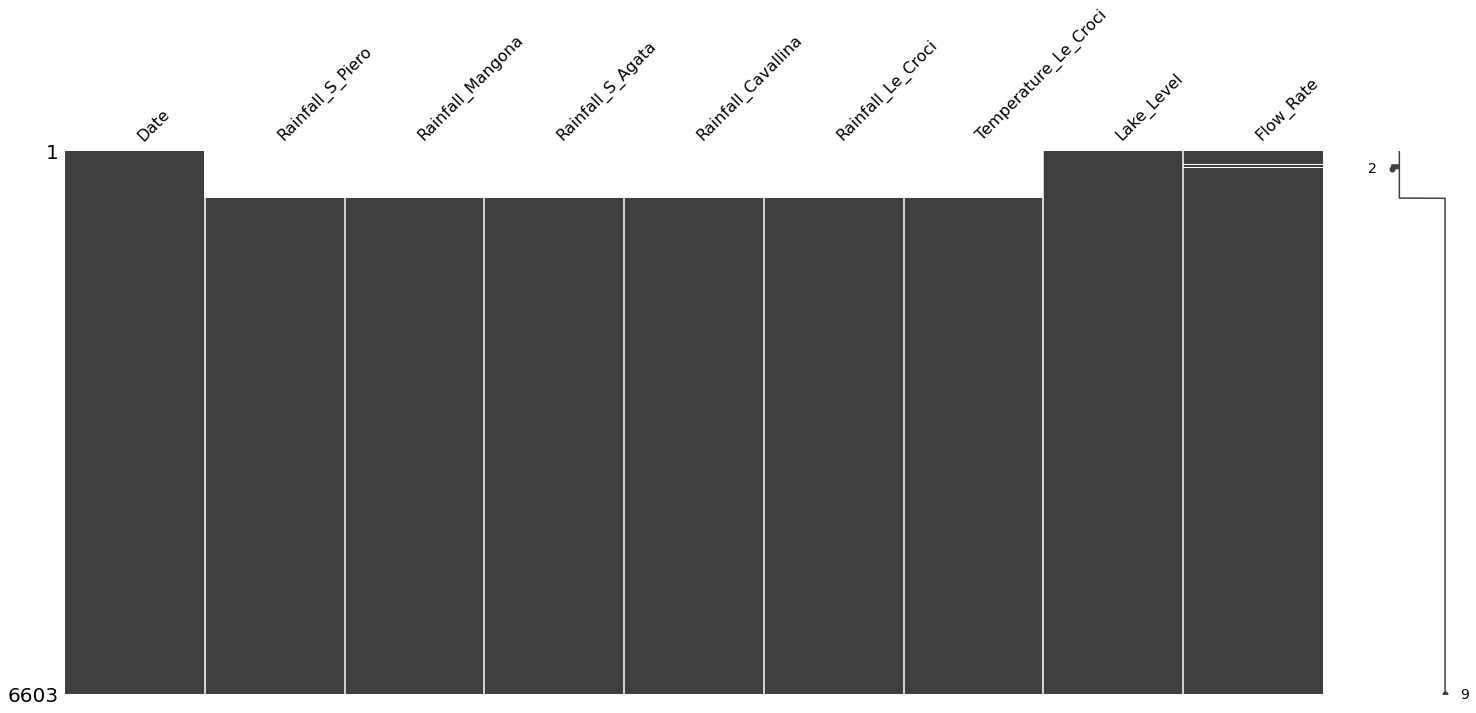

In [0]:
 # convert pypsar DF to pandas DF
df_1 = df.toPandas()
msno.matrix(df_1)

The missing values are only the first 9% rows of the rainfall data for different cities and only 0.32% rows of data are missing in the flow rate columns. This 0.32% is within the 9% of the missing rainfall data.It is reasonable to drop the null values since they account for early years of the data and they follow each other hence they would not disturb the dynamics of the data(since it is a time series).

####Number Summary

In [0]:
# number summary
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+
|summary|  Rainfall_S_Piero|  Rainfall_Mangona| Rainfall_S_Agata|Rainfall_Cavallina| Rainfall_Le_Croci|Temperature_Le_Croci|        Lake_Level|         Flow_Rate|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+
|  count|              6026|              6026|             6026|              6026|              6026|                6025|              6603|              6582|
|   mean|2.4712246929970267|3.3406571523398827|2.670063060073033| 2.674742781281121|3.1298705609027775|  14.530141078838147|249.56409056489406|2.7609677909450125|
| stddev| 6.650011828670297| 8.903134410041547|7.166642638043079| 7.655846526244682| 8.025120759412886|   6.944028580847047| 2.172558106639645| 4.073427589720911|
|    min|             

From the number summary, we see that Rainfall data has minimum values equal to zero. Zero suggests that the was no rainfall, for the day. Now let's see how many times was a zero rainfall measured.

In [0]:
# Check how many values are zeros in each column of the dateframe
cols = ['Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci']

for col_name in cols:
    
    #print(df.filter(col("name").isNotNull()).count())
    
    value = np.round(100*df.filter(df[col_name] == 0).count()/df.count(), 2)
    
    
    print(f"Feature: '{col_name}' has {value}% of values are equal to zero") 

Feature: 'Rainfall_S_Piero' has 55.72% of values are equal to zero
Feature: 'Rainfall_Mangona' has 57.88% of values are equal to zero
Feature: 'Rainfall_S_Agata' has 56.87% of values are equal to zero
Feature: 'Rainfall_Cavallina' has 62.46% of values are equal to zero
Feature: 'Rainfall_Le_Croci' has 57.23% of values are equal to zero


We see that over 50% of the data was zero rainfall. This makes sense because italy is not a rainy place, hence most of the time, there will be zero rainfall measured.

####Feature Distribution and Skewness

Let's look at how our features are distributed and skewed.

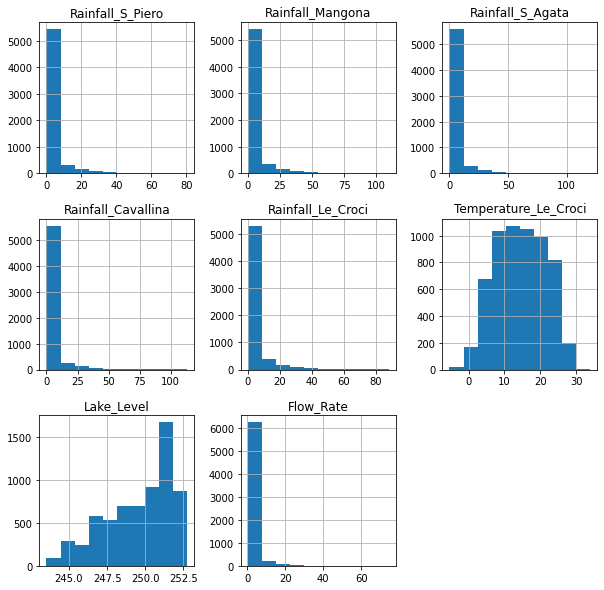

In [0]:
features = ['Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate']


df_1[features].hist(figsize = (10,10));

In [0]:
df_1.kurtosis()

Out[14]: Rainfall_S_Piero        22.773564
Rainfall_Mangona        27.757675
Rainfall_S_Agata        38.739710
Rainfall_Cavallina      30.368678
Rainfall_Le_Croci       19.064878
Temperature_Le_Croci    -0.902505
Lake_Level              -0.515580
Flow_Rate               60.195783
dtype: float64

- Rainfall data shows presence of outliers. This is expected as most the the values in the data set are zeros, hence when a rainfall is recorded, it would be an outlier relative to the zero measurements. It would then be unwise to discard the values labelled as 'outliers'.
- Temperature and lake level, show a lack or absence of outliers. This shows accuracy in the measurements.
- Flow rate shows presence of outliers, it's same as rainfall data, when the lake level is low, a low value of flow rate will be measured. Hence, we cannot just discard these values or replace them.

####Correlation

We look at the degree to which two variables change together, if at all. If two features have a strong positive correlation, it means that if the value of one feature increases, the value of the other feature also increases.

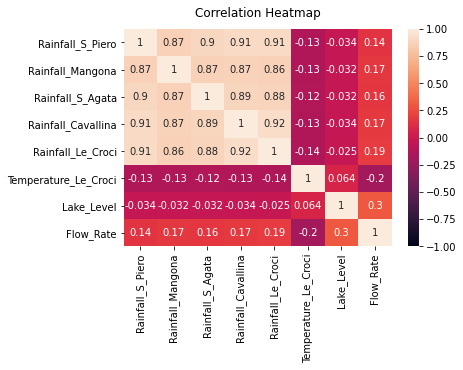

In [0]:
# correlation
heatmap = sns.heatmap(df_1.corr(), vmin = -1, vmax = 1, annot = True)

heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize':12}, pad = 12);

- There’s a high correlation between the rainfall features of different places.  This makes sense because these places are closer to one another...even though the amount of rain may not be equal in these places, but it maybe to the measurement of the other places.
- The negative correlation between the rainfall and temperature may be account for by the fact that a low temperature is expected when it’s raining, Also larger amounts of rain are recorded during the winter season.
- Both rainfall and temperature have a low correlation with Flow_Rate and Lake_Level. This is because these affect features like level, flow some time after it rained.
- The small, negative correlation between the lake_level and rainfall : lake_level should decrease in summer because that’s when the water of the lake is poured into the Arno river.
- The small, positive correlation between the Flow rate and rainfall: If it happens that the lake level is at maximum, even if it rains, water will flow out of the lake, hence the flow rate will increase. Otherwise, there can be a small increase in flow rate with an increase in rainfall. There are instances where the flow rate will increase even if there's no rain measured, this is when the water is poured into the Arnor river.

####Lake Level vs time

We look to see how the lake level varies with time(Through out the years to be precise).

Out[40]: <matplotlib.legend.Legend at 0x7f08dc380af0>

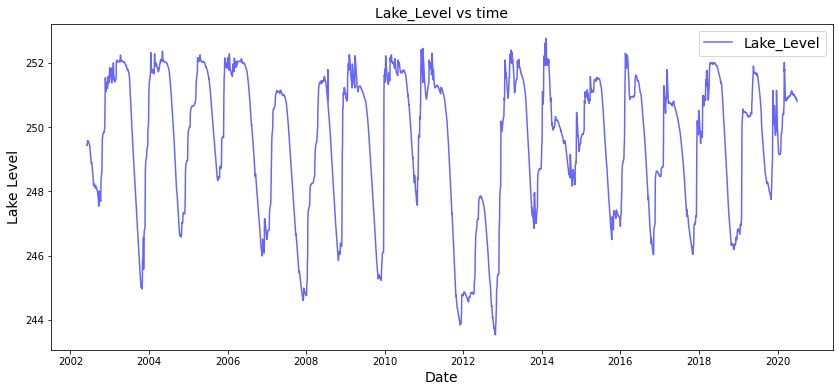

In [0]:
# plot lake level vs time
x_data = df_1[['Date']] # x data
y1 = df_1[['Lake_Level']] # y data
plt.figure(figsize=(14,6)) # figure size
plt.plot(x_data.Date, y1, label = 'Lake_Level', alpha = 0.6, color = 'blue') # plot attributes
plt.xlabel('Date', {'size': 14}) # horizontal label formatting
plt.ylabel('Lake Level', {'size': 14}) # vertical label formatting
plt.title('Lake_Level vs time', {'size': 14}) # title formatting
plt.legend(fontsize = 14,facecolor = 'white') # legend formatting

- The shape is sinusoidal (not a perfect one though). This is expected because the lake is used to refill the Arno river during the summer months. During the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

####Lake Level vs time

We look to see how the Flow rate varies with time.

Out[41]: <matplotlib.legend.Legend at 0x7f08dc396d60>

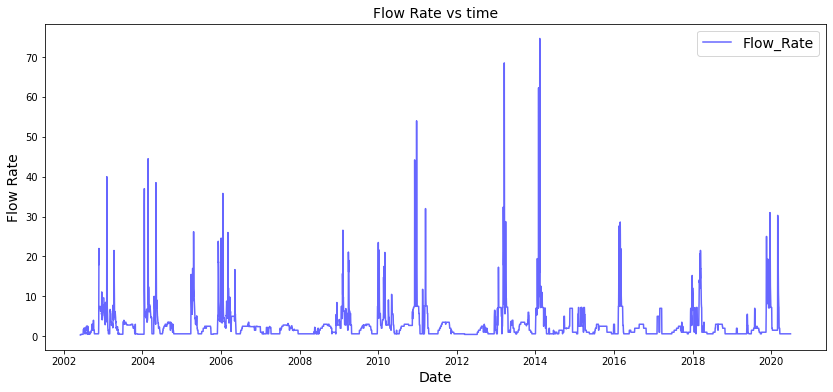

In [0]:
# plot flow_Rate vs time
y2 = df_1[['Flow_Rate']]
x_data = df_1[['Date']] # x data

plt.figure(figsize=(14,6)) # figure size
plt.plot(x_data.Date, y2, label = 'Flow_Rate', alpha = 0.6, color = 'blue') # plot attributes
plt.xlabel('Date', {'size': 14}) # horizontal label formatting
plt.ylabel('Flow Rate', {'size': 14}) # vertical label formatting
plt.title('Flow Rate vs time', {'size': 14}) # title formatting
plt.legend(fontsize = 14,facecolor = 'white') # legend formatting

- There are time when high spikes are experienced. This corresponds to a decrease in lake level. This is during the summer months when the water of the lake is poured into the Arno river.

####Rainfall_S_Agata vs Date

The rainfall data is highly correlated to one another. This place is where the highest rainfall was measured. We check how it varies with time.

Out[42]: <matplotlib.legend.Legend at 0x7f08dc55cfd0>

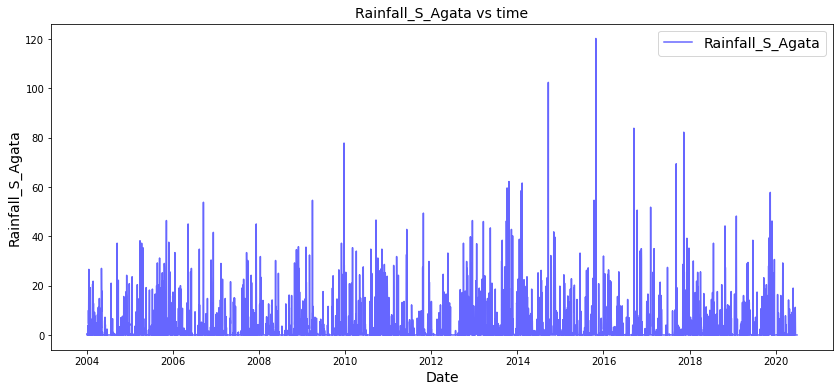

In [0]:
# plot Rainfall_S_Agata vs time
x_data = df_1[['Date']] # x data

y1 = df_1[['Rainfall_S_Agata']] # y data

plt.figure(figsize = (14,6)) # figure size
plt.plot(x_data.Date, y1, label = 'Rainfall_S_Agata', alpha = 0.6, color = 'blue') # plot attributes
plt.xlabel('Date', {'size': 14}) # horizontal label formatting
plt.ylabel('Rainfall_S_Agata', {'size': 14}) # vertical label formatting
plt.title('Rainfall_S_Agata vs time', {'size': 14}) # title formatting
plt.legend(fontsize = 14,facecolor = 'white') # legend formatting

- We see that rainfall measurement is concentrated around zero. This is expected because most our measurements are zero and it hardly rains during summer seasons.

We see that the lake level, flow rate and rainfall would need to be further investigated in months to understand what happens in a monthly basis. We then engineer Month, day and year features.

In [0]:
# Month
df_analysis = df.withColumn('Month', month(df['Date']))

# dayofmonth
df_analysis = df_analysis.withColumn('Day_of_Month', dayofmonth(df['Date']))

# year
df_analysis = df_analysis.withColumn('Year', year(df['Date']))

Adding a new column with average.

In [0]:
# average lake level by month
mean_lake_level = df_analysis.groupBy('Month').mean('Lake_Level')

# average flow rate by month
mean_flow_rate = df_analysis.groupBy('Month').mean('Flow_Rate')

# average Rainfall_S_Agata by month
mean_Rainfall_S_Agata = df_analysis.groupBy('Month').mean('Rainfall_S_Agata')

Renaming the column containing the average.

In [0]:
# lake level df
lake_avg = mean_lake_level.withColumnRenamed('avg(Lake_Level)', 'avg_lake_level')

lake_level_avg = lake_avg.toPandas()

# flow rate df
flow_avg = mean_flow_rate.withColumnRenamed('avg(Flow_Rate)', 'avg_flow_rate')

flow_rate_avg = flow_avg.toPandas()

# Rainfall_S_Agata df
Rainfall_S_Agata = mean_Rainfall_S_Agata.withColumnRenamed('avg(Rainfall_S_Agata)', 'avg_Rainfall_S_Agata')

Rainfall_S_Agata_avg = Rainfall_S_Agata.toPandas()

In [0]:
lake_level_avg.head()

,Month,avg_lake_level
0,12,248.689695
1,1,249.577634
2,6,251.090528
3,3,250.926201
4,5,251.217616


In [0]:
flow_rate_avg.head()

,Month,avg_flow_rate
0,12,3.453905
1,1,3.722767
2,6,0.754789
3,3,5.544480
4,5,1.903459


In [0]:
Rainfall_S_Agata_avg.head()

,Month,avg_Rainfall_S_Agata
0,12,3.560484
1,1,2.782543
2,6,1.558824
3,3,2.855028
4,5,2.516888


####Average lake level vs Month

We look to see how the lake level behaves by month.

Out[26]: <AxesSubplot:xlabel='Month', ylabel='avg_lake_level'>

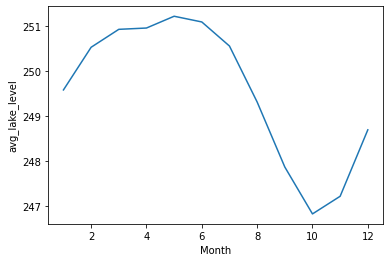

In [0]:
# plot avg_lake_level vs month

y_graph = lake_level_avg[['avg_lake_level']] # y data
x_graph = lake_level_avg[['Month']] # x data

sns.lineplot(data = lake_level_avg, x = "Month", y = "avg_lake_level")


- The lake level decreases from June(6) to October(10); this is when the water water is poured into Arno river.
- In addition, the rains in spring(April - June) slightly increase in comparison with winter (January - March), instead of decreasing. Autumn (October - December) is the wettest season.  Hence we see the increase in the lake level from the 10th month (October) up to 6th month (Which is the peek level).

####Average Flow rate vs Month

We look to see how the Flow rate change by month.

Out[51]: <AxesSubplot:xlabel='Month', ylabel='avg_flow_rate'>

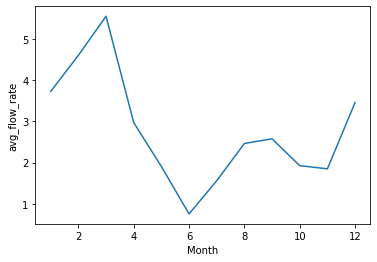

In [0]:
# plot avg_flow_rate vs month

y_graph = flow_rate_avg[['avg_flow_rate']] # y data

x_graph = flow_rate_avg[['Month']] # x data

sns.lineplot(data = flow_rate_avg, x = "Month", y = "avg_flow_rate")

- The flow rate increases from June(6) to September; this is when the water water is poured into Arno river.
- It slightly drops. This is when the Autumn starts which is the wettest season, this is when the lake is filled and there's less water flowing out.  
- We see an increase from the 11th month (November) up to 3rd month (Which is the peek level). This is may be because the lake level is increasing and some water is allowed to flow out of the lake.
- It then decreases in spring(April - June) there's less rainfall, hence less water leaves the lake.
- There's a bit of contradiction between the flow rate and lake level.

Out[50]: <AxesSubplot:xlabel='Month', ylabel='avg_Rainfall_S_Agata'>

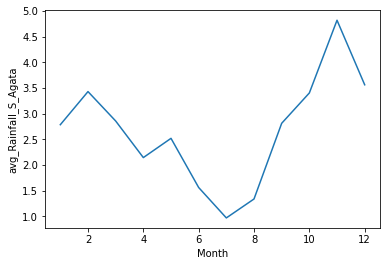

In [0]:
# plot avg_Rainfall_S_Agata vs month

y_graph = Rainfall_S_Agata_avg[['avg_Rainfall_S_Agata']] # y data

x_graph = Rainfall_S_Agata_avg[['Month']] # x data

sns.lineplot(data = Rainfall_S_Agata_avg, x = "Month", y = "avg_Rainfall_S_Agata")

- The average rainfall starts to increase from July(7), this is when the summer months are starting to end, hence rainy months are starting so the rainfall level will increase, which is the wettest season.  
- It then decreases in spring there's less rainfall until the lowest rainfall in summer months.